In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
plt.style.use(["science","grid"])
def normalise(arr):
    arrmax = np.max(arr)
    arrmin = np.min(arr)
    
    arrnorm = (arr - arrmin) / (arrmax - arrmin)
    
    return arrnorm
def ticks_labels(nb_days):
    if 30%nb_days != 0:
        raise ValueError 
    else:
        vec = np.linspace(0,4320,int(30/nb_days)+1)
        labs = list()
        for i in range(int(30/nb_days)+1):
            labs.append("Day %s"%(i*nb_days))
        return vec,labs

my_palette = {}
my_palette['dark'] = ['midnightblue', 'chocolate', 'darkolivegreen']
my_palette['light'] = ['cornflowerblue','orange','yellowgreen']
my_palette['reds'] = []

In [2]:
# data1 = pd.read_feather("./capacity/capacity30_beta0.0") # rerouting 30                        
# data2 = pd.read_feather("./capacity/capacity30_beta1.0") # rerouting 30

# input1 = pd.read_csv("./capacity/input_parameters_capacity30_beta0.0.csv")
# input2 = pd.read_csv("./capacity/input_parameters_capacity30_beta1.0.csv")

# data2.o0 = data2.o0 + len(input1)

data = pd.read_feather("./capacity/capacity30")#data2 #pd.concat([data1,data2]).reset_index()
input_vars = pd.read_csv("./capacity/input_parameters_capacity30.csv") #pd.concat([input1,input2]).reset_index()

In [7]:
q_sum = list()
n_facs = 12
for j in input_vars.index:
    tmp_sum = 0
    for i in range(n_facs):
        tmp_sum += ( np.sum(data[data.o0==j].iloc[:,i+4]))  
    
    q_sum.append(tmp_sum)    

uc_endvals_dict = {}
for i in ["unsatisfied consumption","policy type","variation","allfacs","fac5","distance"]:
    uc_endvals_dict[i] = list()
    
uc_endvals_dict["fac5"] = list()


for j in input_vars.index:
    uc_endvals_dict["unsatisfied consumption"].append(data.o1[data.o0==j].iloc[-1])
    uc_endvals_dict["distance"].append(data.o3[data.o0==j].iloc[-1])
    uc_endvals_dict["fac5"].append( np.sum(data[data.o0==j].iloc[:,9]))
    uc_endvals_dict["allfacs"].append( q_sum[j] )

    if input_vars.capacity_policy[j] > 0:
        uc_endvals_dict["policy type"].append(1)
        uc_endvals_dict["variation"].append(input_vars.capacity_policy[j])
    else:
        uc_endvals_dict["policy type"].append(0)
        uc_endvals_dict["variation"].append(0)    

uc_endvals_df = pd.DataFrame(uc_endvals_dict)
input_vars_filtered = pd.concat([input_vars,uc_endvals_df],axis=1)

In [91]:
input_vars_filtered["fac5"].iloc[-3]

112983.0

In [86]:
input_vars_filtered.iloc[-3,:]

Unnamed: 0                    477.000000
capacity_policy                 0.000000
minfood_access_policy           0.000000
ration_size_policy             30.000000
day_access_policy               0.000000
rerouting_policy                0.000000
alpha                           0.000000
beta                            1.000000
gamma                           7.000000
epsilon                         1.000000
parallel_served_full            7.800000
avg_interactions               20.000000
unsatisfied consumption      2441.884633
policy type                     0.000000
variation                       0.000000
allfacs                    271315.000000
fac5                       112983.000000
distance                    91530.666667
Name: 477, dtype: float64

In [99]:
for i in range(12):
    print(i, " ",np.sum(data[data.o0==477].iloc[:,i+4]))
print("\n")
for i in range(12):
    print(i, " ",np.sum(data[data.o0==478].iloc[:,i+4]))

0   28190.0
1   1217.0
2   45780.0
3   6364.0
4   2026.0
5   112983.0
6   4212.0
7   350.0
8   69642.0
9   0.0
10   51.0
11   500.0


0   27303.0
1   13722.0
2   29651.0
3   6077.0
4   11751.0
5   22331.0
6   15669.0
7   8930.0
8   35343.0
9   0.0
10   718.0
11   6826.0


/home/daan/miniconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 35.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


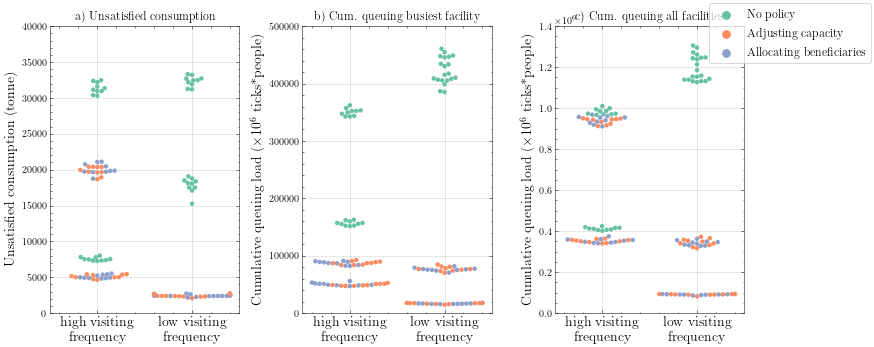

In [78]:
fig, ax = plt.subplots(1,3,figsize=(12.5,5))
# tmp = pd.concat([input_vars_filtered,pd.DataFrame({'x':np.ones(len(input_vars_filtered))})],axis=1)

gs = [[3.0,7.8],[7.0,6.0]]
tmp2 = input_vars_filtered[input_vars_filtered.gamma==3]
tmp2 = tmp2[tmp2.parallel_served_full==7.8]
tmp1 = input_vars_filtered[input_vars_filtered.gamma==7]
tmp1 = tmp1[tmp1.parallel_served_full==6.0]
tmp = pd.concat([tmp1,tmp2])
tmp = tmp[tmp.beta==1.0]

# sns.swarmplot(ax=ax[0] ,x='gamma',hue='variation', y="unsatisfied consumption", data=tmp,size=4.5)#palette=my_palette['dark'])
# sns.swarmplot(ax=ax[1] ,x='gamma',hue='variation', y="fac5", data=tmp,size=4.5)#palette=my_palette['dark'])
# sns.swarmplot(ax=ax[2] ,x='gamma',hue='variation', y="allfacs", data=tmp,size=4.5)#palette=my_palette['dark'])


ylims = [ [0,40e3],[0,500e3],[0,1.4e6]]
ylabels = ["Unsatisfied consumption (tonne)",r"Cumulative queuing load ($\times10^6$ ticks*people)",r"Cumulative queuing load ($\times10^6$ ticks*people)"]
titles = ["a) Unsatisfied consumption","b) Cum. queuing busiest facility","c) Cum. queuing all facilities"]
strings = ["unsatisfied consumption","fac5","allfacs"]
yticks = [np.linspace(0,40,9), np.round(np.linspace(0,0.5,6),1),np.round(np.linspace(0,1.4,8),1)]
for i in range(len(strings)):
    sns.swarmplot(ax=ax[i],x="gamma",y=strings[i],hue='variation',data=tmp,palette="Set2",size=4.5)
    ax[i].set_ylim(ylims[i])
    ax[i].set_xticklabels(["high visiting\nfrequency","low visiting\nfrequency"],fontsize=14)
    ax[i].set_ylabel(ylabels[i],fontsize=14)
    ax[i].set_xlabel(None)
    ax[i].set_title(titles[i])
    ax[i].yaxis.grid(True) # Hide the horizontal gridlines
    ax[i].xaxis.grid(True) # Show the vertical gridlines
#     ax[i].set_yticklabels(yticks[i])
ax[0].get_legend().remove()
ax[1].get_legend().remove()
handles = ax[i].get_legend_handles_labels()[0]
ax[2].legend(handles[:3], ["No policy","Adjusting capacity","Allocating beneficiaries"],loc='upper right',fontsize=12,bbox_to_anchor=(1.7, 1.1),framealpha=0.75)
fig.tight_layout() 
plt.savefig("/home/daan/Desktop/capacity_otherkpis.png")

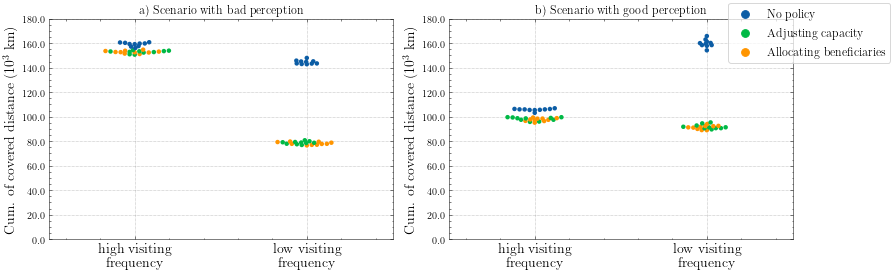

In [67]:
fig, ax = plt.subplots(1,2,figsize=(12.5,4))

epsilons = [0.1,1.0]
titles = ["a) Scenario with bad perception","b) Scenario with good perception"]
for i in range(len(epsilons)):
    
    sns.swarmplot(ax=ax[i] ,x='gamma',hue='variation', y="distance", data=tmp[tmp.epsilon==epsilons[i]],size=4.5)#palette=my_palette['dark'])

    ax[i].set_ylim([0,180e3])
    ax[i].set_xticklabels(["high visiting\nfrequency","low visiting\nfrequency"],fontsize=14)
    ax[i].set_ylabel(r"Cum. of covered distance ($10^3$ km)",fontsize=14)
    ax[i].set_xlabel(None)
    ax[i].set_title(titles[i])
    ax[i].yaxis.grid(True) # Hide the horizontal gridlines
    ax[i].xaxis.grid(True) # Show the vertical gridlines
    
    ax[i].set_yticklabels(np.linspace(0,180,10))

    
    
ax[0].get_legend().remove()
handles = ax[1].get_legend_handles_labels()[0]
ax[1].legend(handles[:3], ["No policy","Adjusting capacity","Allocating beneficiaries"],loc='upper right',fontsize=12,bbox_to_anchor=(1.3, 1.1),framealpha=0.75)
# ax[0].set_yticklabels(np.linspace(0,40,9))
fig.tight_layout();
plt.savefig("/home/daan/Desktop/capacity_distance.png")